In [18]:
import numpy as np
import pandas as pd
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Simulator, Data, Current, Learner
import os
import matplotlib.pyplot as plt

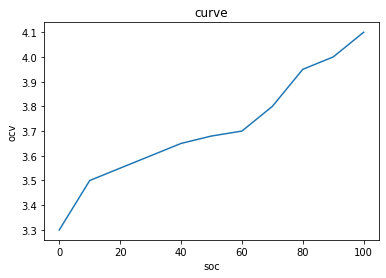

In [19]:
ocv = [3.3, 3.5, 3.55, 3.6, 3.65, 3.68, 3.70, 3.8, 3.95, 4.0, 4.1]
soc = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

In [20]:
param = {
 "R0": 0.034,
 "R1": 0.022,
 "C1": 1500,
 "R2": 0.019,
 "C2": 65000,
 "CAP": 15,
 "ce": 0.96,
 "v_limits": [2.5, 4.5],
 "SOC_RANGE": [0.0, 100.0],
}

m1 = EcmCell(name="cell_model1", parameters=param, curve=c1)
# m1.display()

In [21]:
dt = 0.1
CURR_EXCITATION = 7.5
HOUR = 3600.0
h_steps = [1.75, 0.25, 0.25, 0.25, 1, 1, 1]
current_steps = [
 -CURR_EXCITATION,
 -CURR_EXCITATION / 2,
 -CURR_EXCITATION / 4,
 -CURR_EXCITATION / 8,
 0.0,
 CURR_EXCITATION,
 0.0,
]

initial_soc = 0.0
t_steps = [value * HOUR for value in h_steps]
total_time = sum(t_steps)
samples = int(total_time / dt)

time_np = np.linspace(0.0, total_time, samples)
step_cur = Current(name="current1")

In [22]:
for t_step, current_step in zip(t_steps, current_steps):
 step_cur.add_step(current_step, int(t_step / dt))

data = {"time": time_np, "current": step_cur.current}
df = pd.DataFrame(data)
d1 = Data(name="current_excite", df=df)

In [23]:
s1 = Simulator(name="simulator1")
s1.attach(m1).attach(d1)

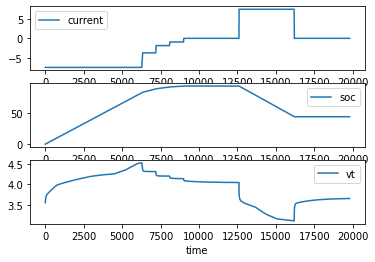

In [24]:
sol = s1.run(
    pair=("cell_model1", "current_excite"),
    x0=np.array([0, 0, initial_soc]),
    config={"solver_type": "adaptive", "solution_name": "sol1"},
)

sol.disp(["current", "soc", "vt"])

In [41]:
TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),'tests\CS2_3_9_28_11.csv')
schema = {
    "Test_Time(s)": "time",
    "Current(A)": "current",
    "Voltage(V)": "vt",
    "rsv_i_dir": True,
}
d1 = Data(name='d1', df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
l1=Learner(name="l1")
# initial guess for R0, R1,C1,R2,C2
p0=[0.034,
0.022,
1500,
0.019,
65000]
x0=np.array([0, 0, initial_soc])
config={"solver_type": None, "solution_name": "sol1"}
res=l1.fit_parameters(p0,d1,c1,config,x0,"ls")
R0,R1,C1,R2,C2=res.x
print("R0:",R0,"R1:",res.x[1],"C1:",res.x[2],"R2:",res.x[3],"C2:",res.x[4])


R0: 0.12298616026096532 R1: 0.021921358632205797 C1: 1500.1076802971825 R2: 0.01911577358264366 C2: 64998.782632190465


0.5542447875460713 -4.987725826806326


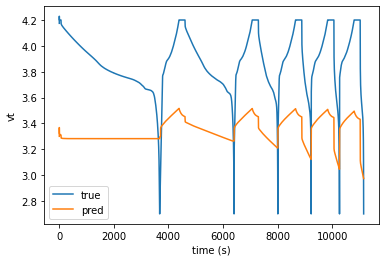

In [39]:
from sklearn.metrics import mean_squared_error,r2_score
y_true=d1.df.vt
y_pred=d1.df.vt-res.fun

rmse=mean_squared_error(y_true, y_pred, squared=False)
r_square=r2_score(y_true, y_pred)
print(rmse,r_square)

plt.plot(y_true,label="true")
plt.plot(y_pred,label="pred")
plt.xlabel('time (s)')
plt.ylabel('vt')
plt.legend()
plt.show()

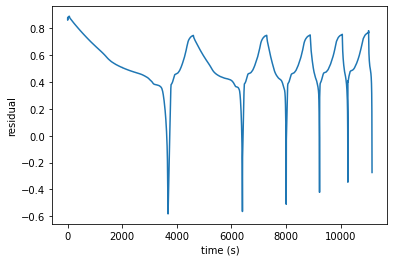

In [40]:
plt.plot(res.fun)
plt.xlabel('time (s)')
plt.ylabel('residual')
plt.show()
# see the residual values

In [29]:
res.status

3